# Прогнозирование объема кредитов МСП с помощью ARIMA

In [77]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import itertools
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
import statsmodels.api as sm
from openpyxl import load_workbook
from statsmodels.tsa.arima.model import ARIMA 

from parser.gdp import get_gdp_dataframe
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_loans_volume_msp_df

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer

In [78]:
warnings.filterwarnings("ignore")

Вспомогательные функции:

In [79]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    
def mape( actual , pred ): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))* 100

# Подготовка датафрейма 

In [80]:
df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024))
df

,msp_loans_volume,month_n,year,Отчетный период
0,452992.0,1,2019,Январь 2019 г.
1,482114.0,2,2019,Февраль 2019 г.
2,604402.0,3,2019,Март 2019 г.
3,686986.0,4,2019,Апрель 2019 г.
4,585284.0,5,2019,Май 2019 г.
...,...,...,...,...
59,1854476.0,12,2023,Декабрь 2023 г.
60,935130.0,1,2024,Январь 2024 г.
61,1216737.0,2,2024,Февраль 2024 г.
62,1524903.0,3,2024,Март 2024 г.


In [81]:
# Извлекаем год из столбца "Отчетный период"
df['date'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)

# Формируем новый столбец "Дата" в формате YYYY-MM
df['date'] = df['date'].astype(str) + '-' + df['month_n'].astype(str)
df['date'] = pd.to_datetime(df['date'])

# Удаляем временные столбцы
df = df[['date', 'msp_loans_volume']]
df = df.reset_index()
df = df.drop('index', axis = 1)
df

,date,msp_loans_volume
0,2019-01-01,452992.0
1,2019-02-01,482114.0
2,2019-03-01,604402.0
3,2019-04-01,686986.0
4,2019-05-01,585284.0
...,...,...
59,2023-12-01,1854476.0
60,2024-01-01,935130.0
61,2024-02-01,1216737.0
62,2024-03-01,1524903.0


Посмотрим на данные:

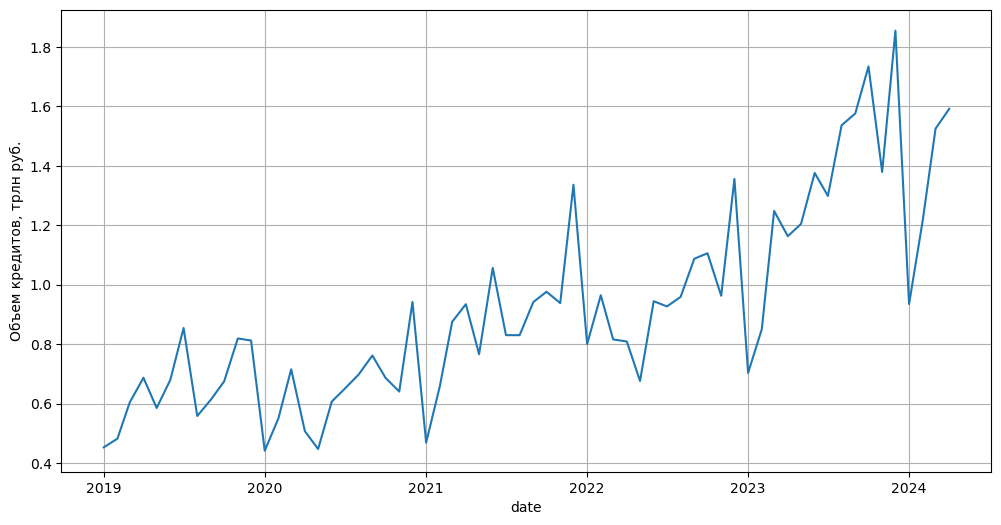

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

Разделим данные на train и test выборки:

In [83]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

train_size =  54
test_size =  10


In [84]:
split_date = df['date'].iloc[train_size]
split_date

Timestamp('2023-07-01 00:00:00')

In [85]:
# разделение данных на тестовые и тренировочные
train = df[df['date']<split_date]
test = df[df['date']>=split_date]

In [86]:
train # тренировочная выборка

,date,msp_loans_volume
0,2019-01-01,452992.0
1,2019-02-01,482114.0
2,2019-03-01,604402.0
3,2019-04-01,686986.0
4,2019-05-01,585284.0
5,2019-06-01,680248.0
6,2019-07-01,854372.0
7,2019-08-01,558370.0
8,2019-09-01,613515.0
9,2019-10-01,674912.0


In [87]:
test # тестовая выборка

,date,msp_loans_volume
54,2023-07-01,1298757.0
55,2023-08-01,1536289.0
56,2023-09-01,1576041.0
57,2023-10-01,1734270.0
58,2023-11-01,1379337.0
59,2023-12-01,1854476.0
60,2024-01-01,935130.0
61,2024-02-01,1216737.0
62,2024-03-01,1524903.0
63,2024-04-01,1591673.0


In [88]:
# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

# Стационарность

(0.6264980607479527, 0.9882508726416358, 11, 42, {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}, 1134.227757090145)


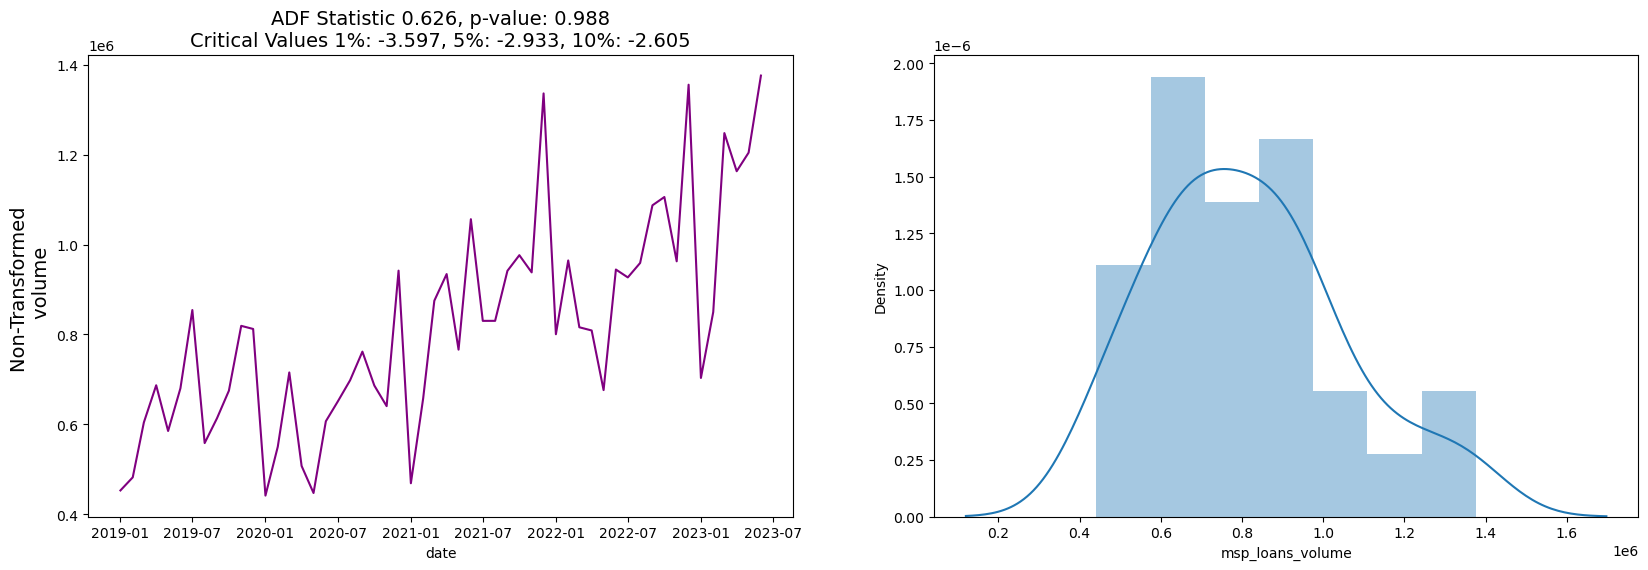

In [89]:
print(adfuller(train['msp_loans_volume'])) # Данные не стационарны

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(train['msp_loans_volume'], 'Non-Transformed \n volume', ax[0])
sns.distplot(train['msp_loans_volume'], ax=ax[1])

plt.show()

Трансформируем данные:

In [90]:
transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
adfuller(trn_transform)# Данные не стационарны

(0.3572303275727101,
 0.979823093458222,
 11,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 -7.889576035577306)

In [91]:
transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

adfuller(trn_transform)# Данные стационарны!

(-5.643975015004436,
 1.0213230695113866e-06,
 4,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 -10.219730822682607)

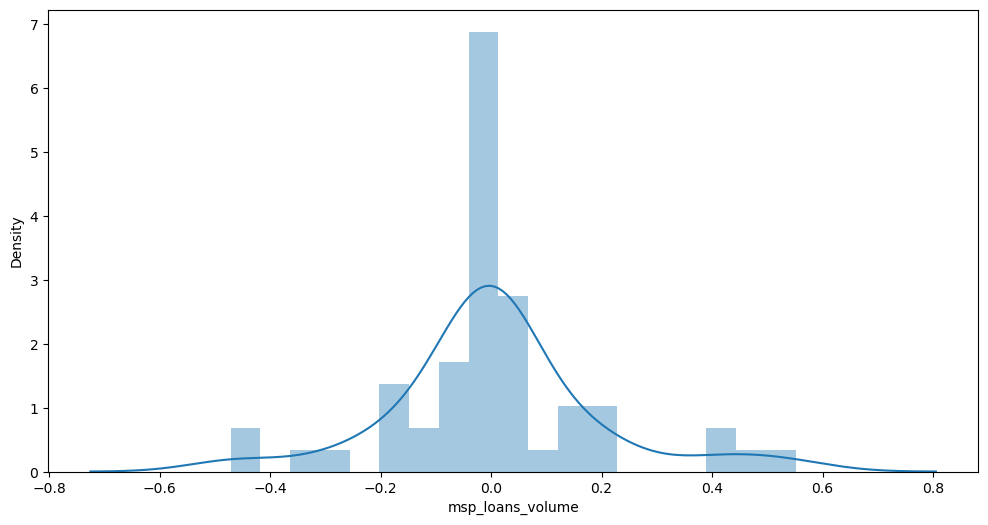

In [92]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(trn_transform)
plt.show()

In [93]:
model = ARIMA(trn_transform, order=(1,1,1))
model_fit = model.fit()
model_fit.aic

-17.488149574891494

In [94]:
model_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       msp_loans_volume   No. Observations:                   54
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  11.744
Date:                Thu, 27 Jun 2024   AIC                            -17.488
Time:                        15:58:24   BIC                            -11.577
Sample:                    01-01-2019   HQIC                           -15.215
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1074      0.198     -0.542      0.588      -0.496       0.281
ma.L1         -0.9985      4.054     -0.246      0.805      -8.945       6.948
sigma2         0.0348      0.141      0.247      0.805      -0.242       0.311
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.49
Prob(Q):                              0.83   Prob(JB):                         0.01
Heteroskedasticity (H):               2.60   Skew:                             0.30
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

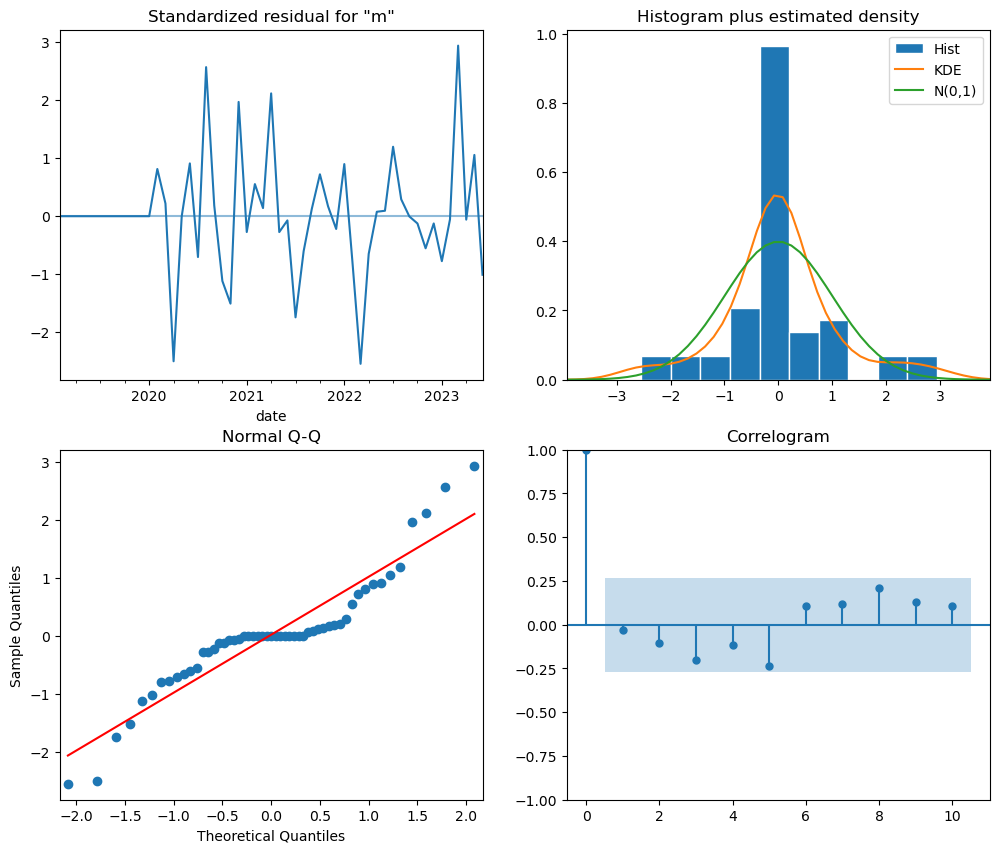

In [95]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

In [96]:
pred = model_fit.get_prediction(start=split_date.strftime('%Y-%m-%d'), end='2025-03-01', dynamic=False)
# The significance level for the confidence interval.
# The default alpha = .05 returns a 95% confidence interval.
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean

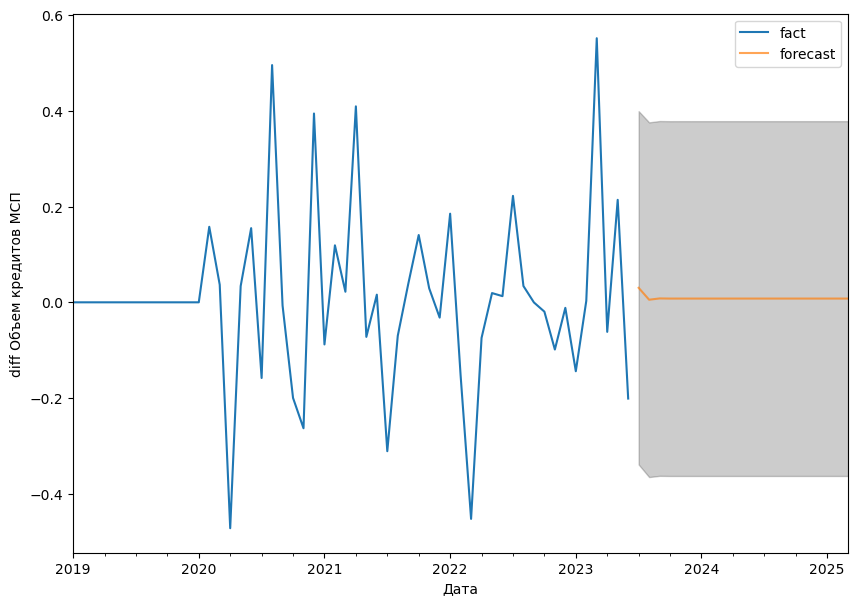

In [97]:
ax = trn_transform.plot(label='fact', figsize=(10, 7))
#ax.set_ylim([-1.5, 1.5])
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Дата')
ax.set_ylabel('diff Объем кредитов МСП')
plt.legend()
plt.show()

In [98]:
res = transformer_2.inverse_transform(vol_diff_pred)
res = transformer_1.inverse_transform(res)
res

2023-07-01    1.392028e+06
2023-08-01    1.448092e+06
2023-09-01    1.655120e+06
2023-10-01    1.696401e+06
2023-11-01    1.488582e+06
2023-12-01    2.112601e+06
2024-01-01    1.104553e+06
2024-02-01    1.345536e+06
2024-03-01    1.991174e+06
2024-04-01    1.870346e+06
2024-05-01    1.952037e+06
2024-06-01    2.247478e+06
2024-07-01    2.291491e+06
2024-08-01    2.402538e+06
2024-09-01    2.767626e+06
2024-10-01    2.858975e+06
2024-11-01    2.528472e+06
2024-12-01    3.616651e+06
2025-01-01    1.905809e+06
2025-02-01    2.339873e+06
2025-03-01    3.489874e+06
Freq: MS, Name: predicted_mean, dtype: float64

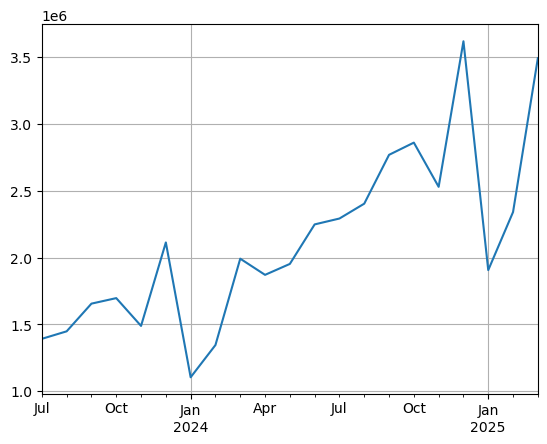

In [99]:
res.plot()
plt.grid(True)

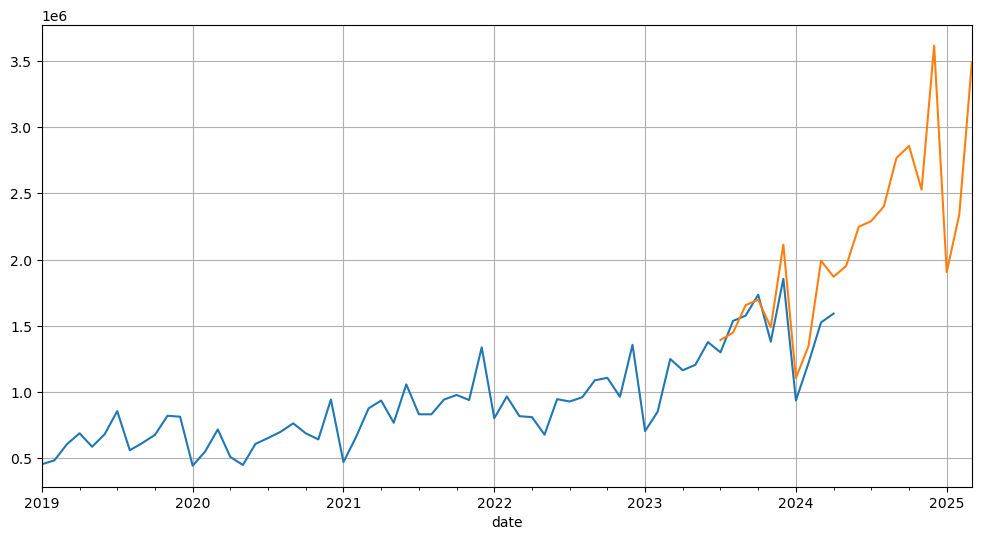

In [100]:
my_df = df.copy()
my_df = my_df[['date','msp_loans_volume']]
my_df['msp_loans_volume'] = my_df['msp_loans_volume'].astype(float)

my_df.set_index(keys='date', drop=True, inplace=True)
my_df = my_df.squeeze(axis=1)

plt.figure(figsize=(12, 6))
my_df.plot()
res.plot()
plt.grid(True)
plt.show()

In [101]:
test_pred = res[0:test_size]
mape(tst_ser.values, test_pred.values)

11.875109743077266

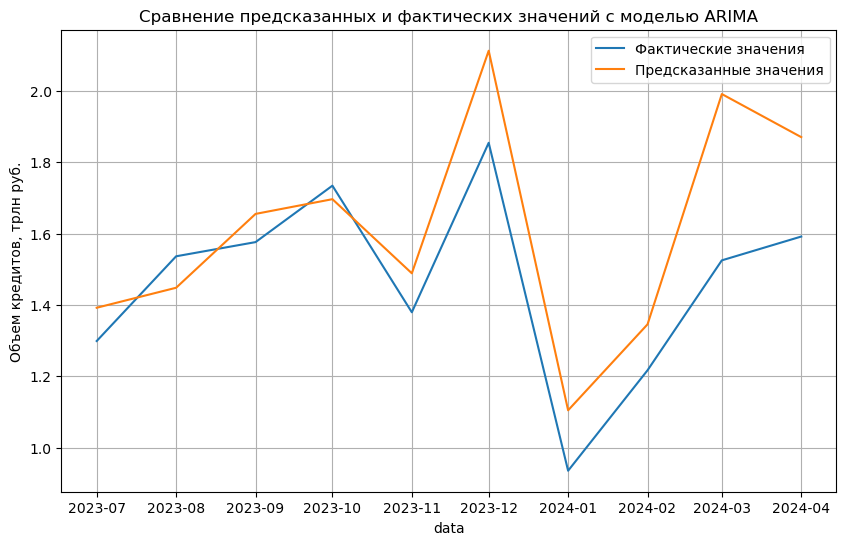

In [103]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()